In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import random
import os
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision import models
from torch.utils.data import DataLoader, Dataset
from collections import Counter
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install xmltodict
import xmltodict

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# you may need to connect to your own driver to load the data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Dataset** 

Images are png files, annotations are xml files. 

In [5]:
img_path = "/content/drive/MyDrive/COM_S_573_Project/data/images/"
xml_path = "/content/drive/MyDrive/COM_S_573_Project/data/annotations/"
imgs = sorted([f for f in os.listdir(img_path)])
xmls = sorted([f for f in os.listdir(xml_path)])

Final all the labels from xml files: "without_mask", "with_mask", "mask_weared_incorrect"

In [6]:
listing = []
for f in xmls:
  fd = open(xml_path + f)
  doc = xmltodict.parse(fd.read())
  obj = doc["annotation"]["object"]
  if type(obj) == list:
    for i in range(len(obj)):
      listing.append(obj[i]["name"])
  else:
    listing.append(obj["name"])

labels = list(Counter(listing).keys())
values = list(Counter(listing).values())

print("Labels:", labels)
print("Number of each labels:", values)


Labels: ['without_mask', 'with_mask', 'mask_weared_incorrect']
Number of each labels: [717, 3232, 123]


Visualize labels numbers and percentage in the dataset

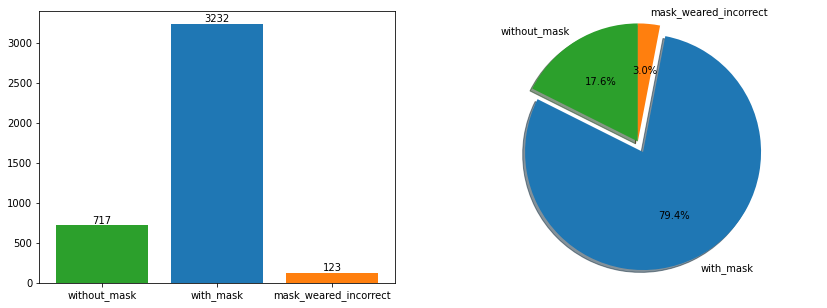

In [7]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

colors = ["tab:green", "tab:blue", "tab:orange"]

ax1.bar(labels, values, align="center", color=colors)

for i in range(len(values)):
  ax1.annotate(str(values[i]), xy=(labels[i], values[i]), ha="center", va="bottom")

explode = (0, 0.1, 0)
ax2.pie(values, labels=labels, explode=explode, autopct="%1.1f%%", shadow=True, startangle=90, colors=colors)
ax2.axis("equal")

plt.show()

Visualize image detection with target labels. We use blue rectangle for "with_mask", grenn rectangle for "without_mask", and orange rectangle for "mask_weared_incorrect".


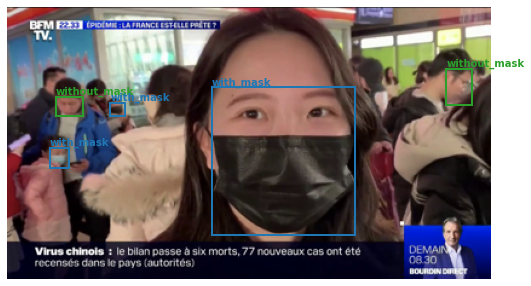

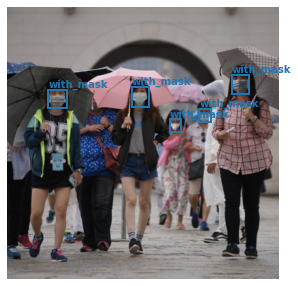

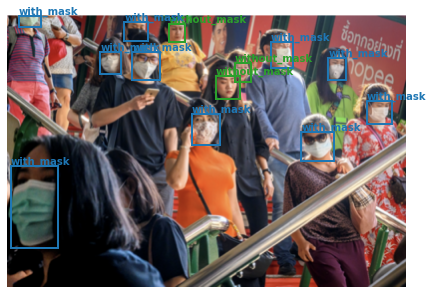

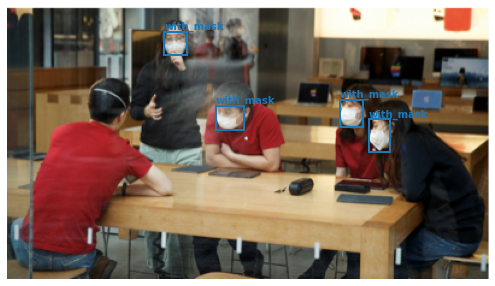

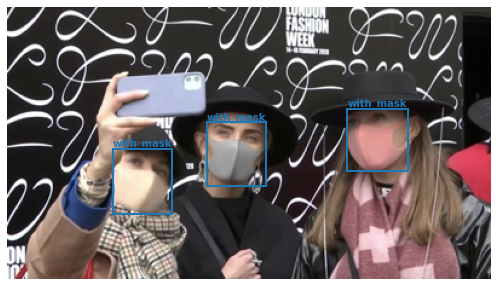

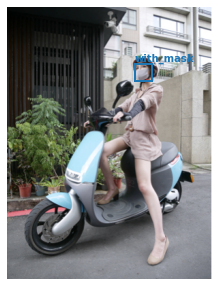

In [8]:
def image_case(xml, img):
  fd = open(xml_path + xml)
  doc = xmltodict.parse(fd.read())
  image = plt.imread(img_path + img)

  fig, ax = plt.subplots(1)
  ax.axis("off")
  fig.set_size_inches(10, 5)

  obj = doc["annotation"]["object"]
  if type(obj) == list:
    for i in range(len(obj)):
      idx = labels.index(obj[i]["name"]) # find the index of the label
      xmin, ymin, xmax, ymax = list(map(int, obj[i]["bndbox"].values()))
      patch = pat.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor=colors[idx], facecolor="none", lw=2)
      ax.add_patch(patch)
      px, py = patch.get_xy()
      ax.annotate(labels[idx], (px, py), color=colors[idx], weight="bold", ha="left", va="bottom")
  else:
    idx = labels.index(obj["name"]) # find the index of the label
    xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
    patch = pat.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor=colors[idx], facecolor="none", lw=2)
    ax.add_patch(patch)
    px, py = patch.get_xy()
    ax.annotate(labels[idx], (px, py), color=colors[idx], weight="bold", ha="left", va="bottom")
  
  ax.imshow(image)

# show the first 10 images and labels
for i in range(6):
  rand = random.randint(0, len(xmls)-1)
  image_case(xmls[rand], imgs[rand])


Create final dataset and process to torch tensors.

labels index: {'without_mask': 0, 'with_mask': 1, 'mask_weared_incorrect': 1}

In [9]:

class FaceMaskDataset(Dataset):
  def __init__(self, imgs, xmls, img_dir, xml_dir):
    self.imgs = imgs
    self.xmls = xmls
    self.img_dir = img_dir
    self.xml_dir = xml_dir

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    xml = self.xmls[idx]
    image = Image.open(self.img_dir + img).convert("RGB")
    #image = transforms.resize(image, (256, 256))
    image = transforms.ToTensor()(image)

    # read annoations
    i_box = []
    i_label = []
    fd = open(self.xml_dir + xml)
    doc = xmltodict.parse(fd.read())
    obj = doc["annotation"]["object"]
    if type(obj) == list:
      for i in range(len(obj)):
        xmin, ymin, xmax, ymax = list(map(int, obj[i]["bndbox"].values()))
        i_box.append([xmin, ymin, xmax, ymax])
        i_label.append(labels.index(obj[i]["name"]))
    else:
      xmin, ymin, xmax, ymax = list(map(int, obj["bndbox"].values()))
      i_box.append([xmin, ymin, xmax, ymax])
      i_label.append(labels.index(obj["name"]))

    # build target tensor
    i_box_tensor = torch.as_tensor(i_box, dtype=torch.float32)
    i_label_tensor = torch.as_tensor(i_label, dtype=torch.int64)
    i_area = (i_box_tensor[:, 2]-i_box_tensor[:, 0]) * (i_box_tensor[:, 3]-i_box_tensor[:, 1])
    i_area_tensor = torch.as_tensor(i_area, dtype=torch.float32)
    iscrowd_tensor = torch.zeros(len(i_box), dtype=torch.int64)

    target = {}
    target["image_id"] = torch.tensor([idx])
    target["boxes"] = i_box_tensor
    target["area"] = i_area_tensor
    target["iscrowd"] = iscrowd_tensor
    target["labels"] = i_label_tensor

    return image, target

Load dataset with dataset loader and split dataset to training data and test data.

In [10]:
mask_dataset = FaceMaskDataset(imgs, xmls, img_path, xml_path)

train_size = int(len(mask_dataset)*0.8)
test_size = len(mask_dataset)-train_size

train_set, test_set = torch.utils.data.random_split(mask_dataset, [train_size, test_size])

def collate_fn(batch):
    return tuple(zip(*batch))

mask_train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
mask_test_loader = DataLoader(test_set, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

**Build Model**

Get GPU device for training

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Setup models and parameters. We use ResNet50 and VGG19.

In [12]:
'''
model = models.resnet50(pretrained=True)
n_inputs = model.fc.in_features
ouput_layers = torch.nn.Linear(n_inputs, 3)
model.fc.out_features = ouput_layers
model = model.to(device)

#model
'''
num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
params = [p for p in model.parameters() if p.requires_grad]
#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

Train model.

In [ ]:
num_epochs = 2

for epoch in range(num_epochs):
  for images, targets in mask_train_loader:
    images = [image.to(device) for image in images]
    targets = [{key:value.to(device) for key, value in target.items()} for target in targets]

    model.train()
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses.backward()
    optimizer.zero_grad()
    optimizer.step()


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
